In [11]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization # to create AdamW optimizer

import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')


This reference tutorial: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [22]:
# download the IMDB dataset
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 123s 1us/step


In [23]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Loading models from TensorFlow Hub  
Here we use Small BERT

In [13]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  

map_name_to_handle = {
  'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
  'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}


tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [24]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2022-04-30 23:20:27.941624: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Load the preprocessing model into a hub.KerasLayer to compose your fine-tuned model. This is the preferred API to load a TF-2 style SaveModel From TF Hub into a Keras model

In [14]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [15]:
# Let's try preprocessing model on some text and see the output
text_test = ['this is such a terrible movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 1037 6659 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.6402765   0.98766613 -0.27000356  0.27107412  0.20650293  0.8040132
  0.97408533 -0.85816294 -0.128796   -0.9961683   0.12511693 -0.9870728 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.15253702  0.3119466   0.00902006 ... -0.10831092  0.6911189
  -0.21715738]
 [-0.28623646  0.4804188  -0.42781755 ...  0.49551052 -0.52481973
   0.6225647 ]
 [-0.38140264  0.8133522  -1.2506602  ... -0.21652016 -0.3773089
   0.38601482]
 ...
 [-0.10772508 -0.33071518 -0.49808678 ...  0.57229006  0.47901273
   0.24779321]
 [-0.12819143 -0.23513404 -0.4712388  ...  0.5156769   0.8964593
   0.03406116]
 [-0.45373043 -0.01247826 -0.38219836 ...  0.07658454  0.92582345
  -0.11577918]]


In [17]:
# Define your model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [18]:
# Check the model runs with the output of the preprocessing model
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.38997963]], shape=(1, 1), dtype=float32)


In [19]:
#print model's structure
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Model training
- loss function
- optimizer
- loading the BERT model and training
- evaluate the model
- plot the accuracy and loss over time

In [20]:
# 1. loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [25]:
# 2. optimizer
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [26]:
# 3. Loading the BERT model and training
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [27]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 1898s 3s/step - loss: 0.4779 - binary_accuracy: 0.7512 - val_loss: 0.3851 - val_binary_accuracy: 0.8324
Epoch 2/5
625/625 [==============================] - 1823s 3s/step - loss: 0.3256 - binary_accuracy: 0.8523 - val_loss: 0.3641 - val_binary_accuracy: 0.8428
Epoch 3/5
625/625 [==============================] - 1827s 3s/step - loss: 0.2516 - binary_accuracy: 0.8935 - val_loss: 0.3941 - val_binary_accuracy: 0.8484
Epoch 4/5
625/625 [==============================] - 1824s 3s/step - loss: 0.1932 - binary_accuracy: 0.9245 - val_loss: 0.4390 - val_binary_accuracy: 0.8492
Epoch 5/5
625/625 [==============================] - 1822s 3s/step - loss: 0.1578 - binary_accuracy: 0.9399 - val_loss: 0.4782 - val_binary_accuracy: 0.8494


In [28]:
# 4. Evaluate the model
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 667s 853ms/step - loss: 0.4541 - binary_accuracy: 0.8530
Loss: 0.45413386821746826
Accuracy: 0.8530399799346924


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


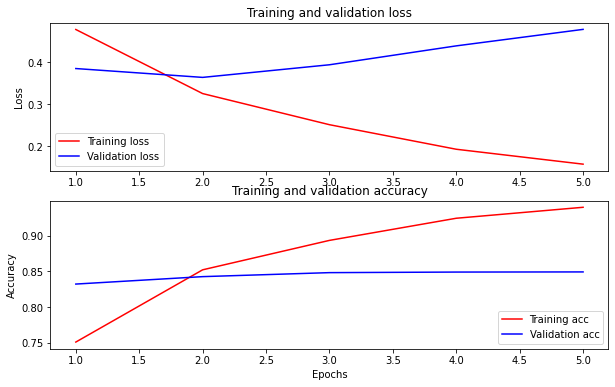

In [29]:
# 5. Plot the accuracy and loss over time
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


### Export for inference
save your fine-tunned model for later use.

In [30]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2022-05-01 02:27:08.682949: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [32]:
# how to reload model
reloaded_model = tf.saved_model.load(saved_model_path)

In [33]:
# Here you can test your model on any sentence you want, just add to the examples variable below
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999573
input: The movie was great!           : score: 0.996898
input: The movie was meh.             : score: 0.946912
input: The movie was okish.           : score: 0.055592
input: The movie was terrible...      : score: 0.000748

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999573
input: The movie was great!           : score: 0.996898
input: The movie was meh.             : score: 0.946912
input: The movie was okish.           : score: 0.055592
input: The movie was terrible...      : score: 0.000748

